# AUTO-MPG regression problem

In [111]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import pandas as pd
import numpy  as np
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


## 1. Dataset is downloaded from Kaggle.com

In [116]:
# does not need car type attribute
df = pd.read_csv("auto-mpg.csv", na_values='?')
df = df.iloc[:, :-1]
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1
394,44.0,4,97.0,52.0,2130,24.6,82,2
395,32.0,4,135.0,84.0,2295,11.6,82,1
396,28.0,4,120.0,79.0,2625,18.6,82,1


In [113]:
pandas_profiling.ProfileReport(df)
# no missing value 

E:\anaconda\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,8
Number of observations,398
Total Missing (%),0.2%
Total size in memory,25.0 KiB
Average record size in memory,64.3 B
Numeric,6
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,2


## 2. Data Preprocessing

### Wash Data

In [117]:
# Because there are only 6 null value, so just drop them.
df = df.dropna()
print(df.isna().sum())
origin = df.pop('origin')
# origin == 1 is True, return 1, 1*1=1, just like one-hot encoding
df['USA'] = (origin == 1)*1.0
df['Europe'] = (origin == 2)*1.0
df['Japan'] = (origin == 3)*1.0
df.head()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model year      0
origin          0
dtype: int64


E:\anaconda\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
E:\anaconda\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
E:\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/ind

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449,10.5,70,1.0,0.0,0.0


### Split the train & test dataset

In [118]:
df_train = df.sample(frac=0.8,random_state=22)
df_test = df.drop(df_train.index)
df_train.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,USA,Europe,Japan
282,22.3,4,140.0,88.0,2890,17.3,79,1.0,0.0,0.0
58,25.0,4,97.5,80.0,2126,17.0,72,1.0,0.0,0.0
47,19.0,6,250.0,100.0,3282,15.0,71,1.0,0.0,0.0
225,17.5,6,250.0,110.0,3520,16.4,77,1.0,0.0,0.0
305,28.4,4,151.0,90.0,2670,16.0,79,1.0,0.0,0.0


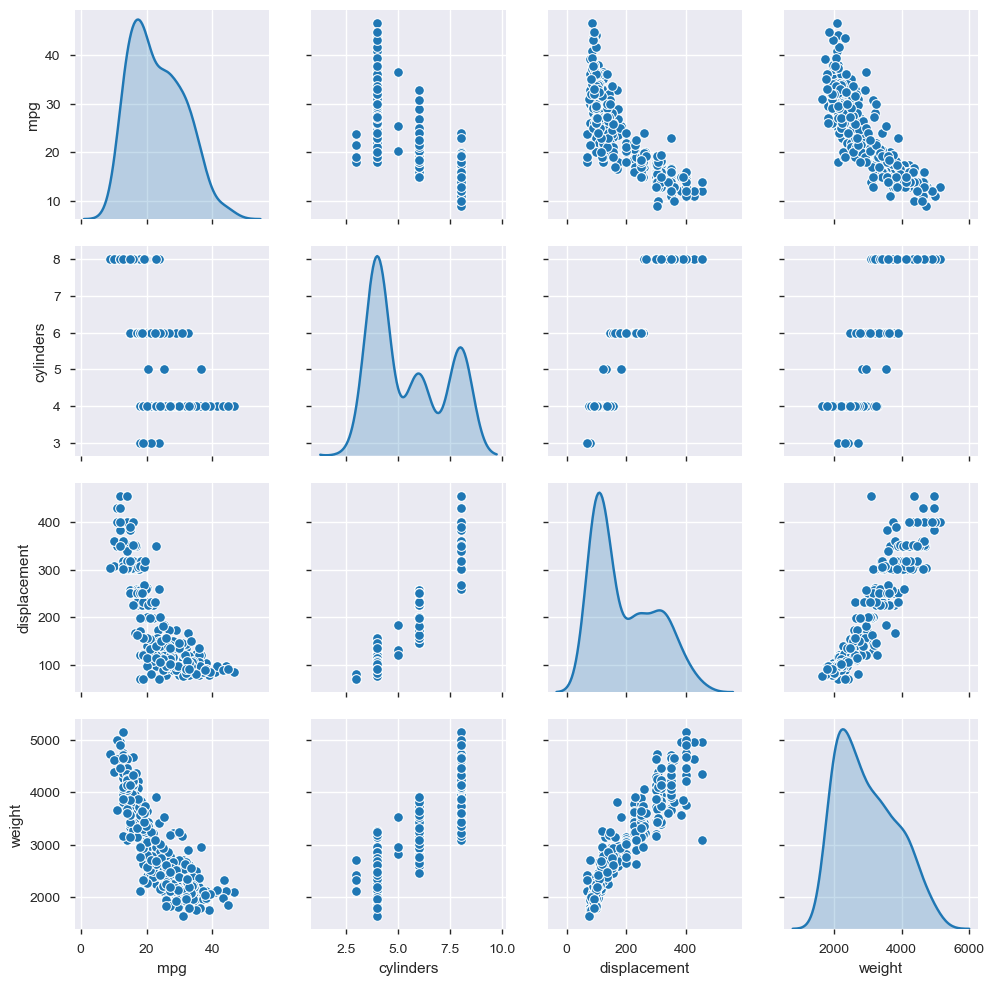

In [75]:
sns.pairplot(df_train[["mpg", "cylinders", "displacement", "weight"]], diag_kind="kde")
plt.show()

In [76]:
train_stats = df_train.describe()
train_stats.pop("mpg")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
cylinders,314.0,5.500000,1.726046,3.0,4.00,4.0,8.00,8.0
displacement,314.0,194.412420,103.558735,70.0,105.00,148.5,302.00,455.0
horsepower,314.0,103.984076,37.004918,46.0,75.00,95.0,129.75,225.0
weight,314.0,2991.442675,849.385106,1649.0,2247.25,2831.5,3638.75,5140.0
acceleration,314.0,15.530892,2.770123,8.0,13.60,15.5,17.00,24.8
model year,314.0,76.092357,3.648415,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.611465,0.488195,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.210191,0.408095,0.0,0.00,0.0,0.00,1.0


In [77]:
train_label = df_train.pop('mpg')
test_label = df_test.pop('mpg')

### Scale data

In [82]:
clf = StandardScaler()
df_train_scaled = clf.fit_transform(df_train)
df_test_scaled = clf.transform(df_test)

## 3. Build model

In [87]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(df_train.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    return model

In [91]:
model = build_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                640       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [93]:
example_batch = df_train_scaled[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.00889267],
       [ 0.03466855],
       [-0.13387577],
       [-0.03695793],
       [-0.04631945],
       [ 0.18206388],
       [-0.08999352],
       [-0.07985771],
       [-0.04647617],
       [ 0.04223688]], dtype=float32)

In [96]:
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
  df_train_scaled, train_label,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [97]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1.906716,0.845677,1.906716,9.744660,2.552427,9.744660,995
996,2.182050,0.947332,2.182050,6.286504,1.955833,6.286504,996
997,1.972179,0.852237,1.972179,6.911252,2.052362,6.911252,997
998,1.912803,0.855903,1.912803,7.121957,2.092316,7.121957,998
999,1.903854,0.823286,1.903855,6.384410,1.964031,6.384410,999


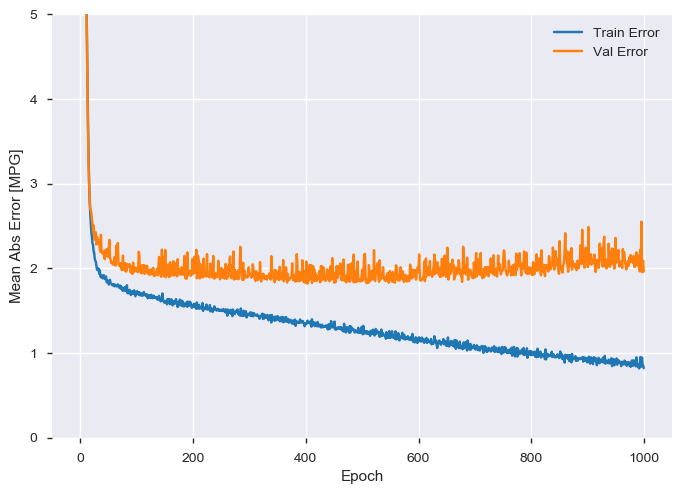

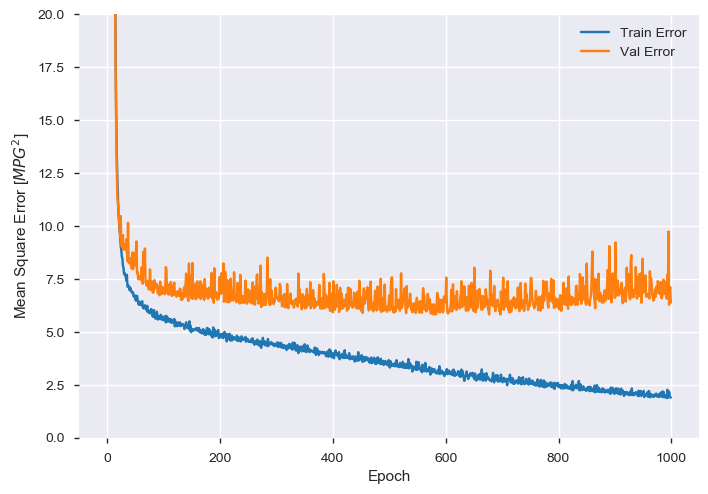

In [98]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


plot_history(history)


....................................................................................................
..............

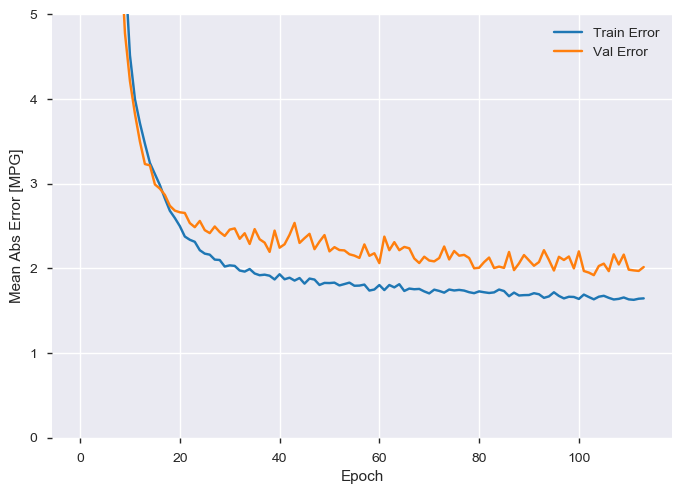

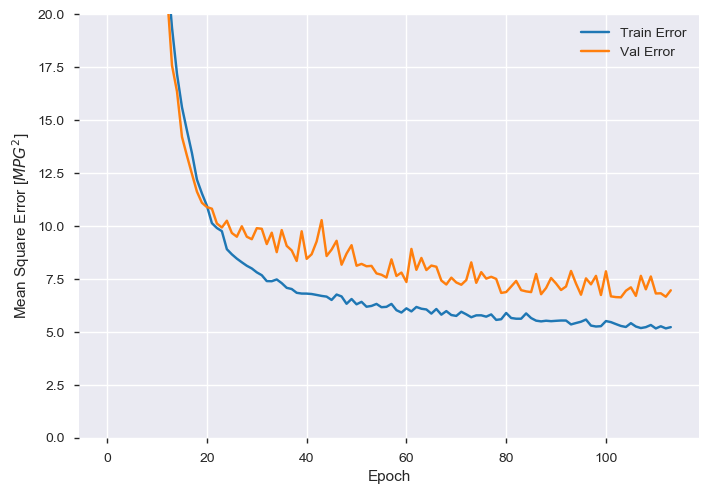

In [99]:
model = build_model()


early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(df_train_scaled, train_label, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [101]:
loss, mae, mse = model.evaluate(df_test_scaled, test_label, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  2.21 MPG


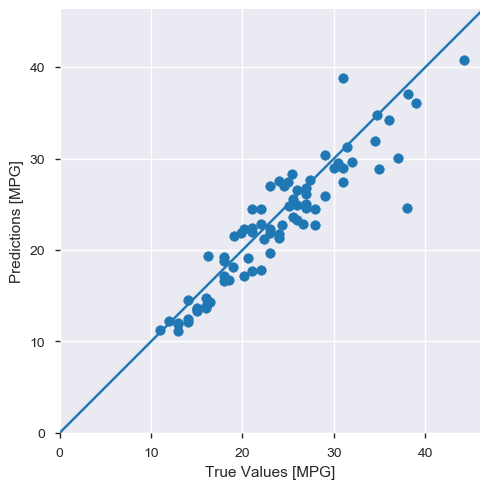

In [105]:
test_predictions = model.predict(df_test_scaled).flatten()
plt.scatter(test_label, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

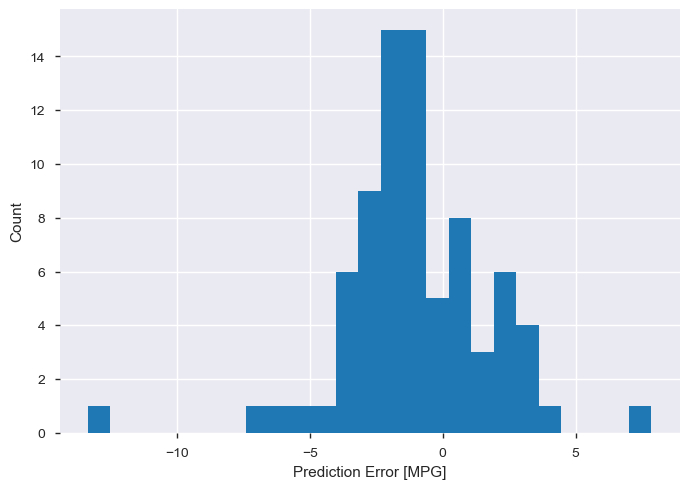

In [106]:
error = test_predictions - test_label
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")